In [158]:
from diffusers import StableDiffusionControlNetInpaintPipeline, ControlNetModel
from diffusers import DDIMScheduler, UniPCMultistepScheduler, DPMSolverMultistepScheduler
from diffusers.utils import load_image
import numpy as np
import torch
import cv2
from PIL import Image
from controlnet_aux import LineartDetector

### Load a pipeline that supports both ControlNet and inpainting so we can use none, one, or both

In [17]:
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/control_v11p_sd15_lineart", torch_dtype=torch.float16
)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5",
    controlnet=controlnet,
    torch_dtype=torch.float16,
    safety_checker=None,
)
pipe = pipe.to("cuda")

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config, use_karras_sigmas=True)
# pipe.enable_model_cpu_offload()

control_image_processor = LineartDetector.from_pretrained("lllyasviel/Annotators")
# control_image_processor = control_image_processor.to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet_inpaint.StableDiffusionControlNetInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


### Plain text-to-image generation, no "control" conditioning, no inpainting

In [190]:
from torchvision import transforms

sd15_image_transform = transforms.Compose([
    transforms.v2.Resize(size=None, max_size=512),
    # transforms.CenterCrop(512),
])

init_image = load_image("./dataset/a.png").resize((512, 512))
init_image = sd15_image_transform(init_image)

# mask_image = load_image(

control_image = control_image_processor(init_image)
control_image = sd15_image_transform(control_image)

# generate image
images = pipe(
    # "mermaid underwater, blue clothes, corals and fishes background",
    prompt=["an astronaut cat, high-quality DSLR photo"] * 5,
    negative_prompt=["worst quality, low quality, blurry, ugly"] * 5,
    image=init_image,
    mask_image=Image.new('L', init_image.size, color='white'), # i.e. inpainting switched off
    strength=1.0,
    control_image=control_image,
    controlnet_conditioning_scale=0.0,  # i.e. lineart control switched off
    guidance_scale=7.5,
    # height=512,
    # width=256,
    eta=0.0,
    num_inference_steps=40,
    generator=torch.Generator(device="cuda").manual_seed(124),
).images

  0%|          | 0/40 [00:00<?, ?it/s]

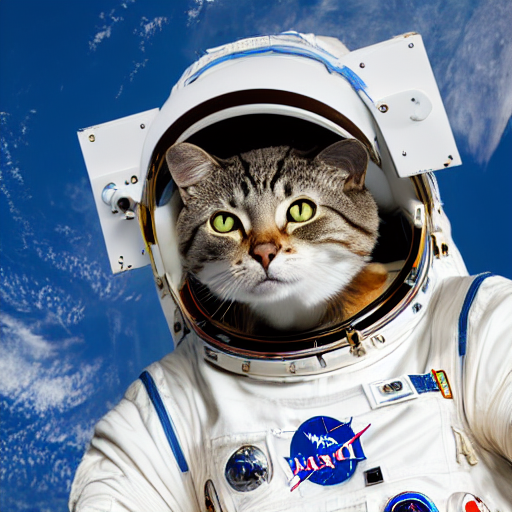

In [198]:
images[3]